<a href="https://colab.research.google.com/github/k906506/PyTorch/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN을 사용해서 이미지 분류기 학습하기
- 이 튜토리얼에서는 CIFAR10 데이터셋을 사용합니다. \\
- 여기에는 다음과 같은 분류들이 있습니다: ‘비행기(airplane)’, ‘자동차(automobile)’, ‘새(bird)’, ‘고양이(cat)’, ‘사슴(deer)’, ‘개(dog)’, ‘개구리(frog)’, ‘말(horse)’, ‘배(ship)’, ‘트럭(truck)’. \\
- 그리고 CIFAR10에 포함된 이미지의 크기는 3x32x32로, 이는 32x32 픽셀 크기의 이미지가 3개 채널(channel)의 색상로 이뤄져 있다는 것을 뜻합니다.


## 이미지 분류기 학습하기
다음과 같은 단계로 진행해보겠습니다:

1. `torchvision` 을 사용하여 CIFAR10의 학습용 / 시험용 데이터셋을 불러오고, 정규화(nomarlizing)합니다.

2. 합성곱 신경망(Convolution Neural Network)을 정의합니다.

3. 손실 함수를 정의합니다.

4. 학습용 데이터를 사용하여 신경망을 학습합니다.

5. 시험용 데이터를 사용하여 신경망을 검사합니다.

###  CIFAR10를 불러오고 정규화하기
`torchvision` 을 사용하여 매우 쉽게 CIFAR10을 불러올 수 있습니다.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지입니다. 이를 [-1, 1]의 범위로 정규화된 Tensor로 변환합니다.



In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


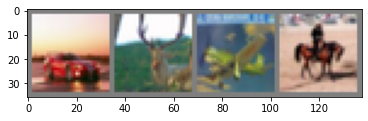


  car  deer plane horse


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 합성곱 신경망(Convolution Neural Network) 정의하기

**입력 값과 출력 값의 형태** \\
- Input: ($N$, $C_{in}$, $H_{in}$, $W_{in}$)
- Output: ($N$, $C_{out}$, $H_{out}$, $W_{out}$)

`torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias, padding_mode)`

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to("cuda")

### 손실 함수와 optimizer 정의하기
교차 엔트로피 손실(Cross-Entropy loss)과 모멘텀(momentum) 값을 갖는 SGD를 사용합니다.

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to("cuda")
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 신경망 학습하기

In [ ]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs.cuda())
        loss = criterion(outputs, labels.to("cuda"))
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.177
[1,  4000] loss: 1.869
[1,  6000] loss: 1.692
[1,  8000] loss: 1.601
[1, 10000] loss: 1.510
[1, 12000] loss: 1.476
[2,  2000] loss: 1.407
[2,  4000] loss: 1.382
[2,  6000] loss: 1.352
[2,  8000] loss: 1.317
[2, 10000] loss: 1.317
[2, 12000] loss: 1.271
Finished Training


In [ ]:
# 학습한 모델을 저장
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 시험용 데이터로 신경망 검사하기
지금까지 학습용 데이터셋을 2회 반복하며 신경망을 학습시켰습니다. 신경망이 전혀 배운게 없을지도 모르니 확인해봅니다.

신경망이 예측한 출력과 진짜 정답(Ground-truth)을 비교하는 방식으로 확인합니다. 만약 예측이 맞다면 샘플을 ‘맞은 예측값(correct predictions)’ 목록에 넣겠습니다.

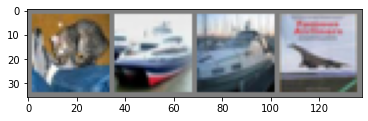

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

이제, 저장했던 모델을 불러오도록 하겠습니다

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
# 시험 데이터에 대한 모델의 예측 결과
outputs = net(images)

출력은 10개 분류 각각에 대한 값으로 나타납니다. 어떤 분류에 대해서 더 높은 값이 나타난다는 것은, 신경망이 그 이미지가 해당 분류에 더 가깝다고 생각한다는 것입니다. 따라서, 가장 높은 값을 갖는 인덱스(index)를 뽑아보겠습니다:

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 46 %
Accuracy of   car : 63 %
Accuracy of  bird : 47 %
Accuracy of   cat : 34 %
Accuracy of  deer : 45 %
Accuracy of   dog : 36 %
Accuracy of  frog : 72 %
Accuracy of horse : 70 %
Accuracy of  ship : 82 %
Accuracy of truck : 57 %
